# Retail Data Wrangling and Analytics

In [1]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpeg)

```
#make sure you have both Jupyter and PSQL docker container running
docker ps

#Attach a bridge network to both containers so they can communicate with each other
docker network create jarvis-net
#this command works on running containers
docker network connect jarvis-net jarvis-jupyter
docker network connect jarvis-net jarvis-psql

#verify both containers are attached to the jarvis-net
docker network inspect trading-net

#Note: instead of using `localhost`, you should use container names as hostnames.
```

**Data Preperation**

- Use [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame

![](https://i.imgur.com/AmkAP63.jpg)

- Get familair with the transaction date with `df.head()`, `df.sample(10)`, `df.info()`, `df.describe()`, etc..



In [2]:
#install psql "driver"
!pip3 install psycopg2-binary

In [3]:
import psycopg2 as pg 

In [75]:
#Write your code in one or more cells (please remove this line from your notebook)

engine_string = "dbname=postgres user=postgres password=password host=jrvs-psql port=5432"
engine = pg.connect(engine_string)
retail_df = pd.read_sql("SELECT * FROM retail", engine)
retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [64]:
retail_df = pd.read_csv("data/online_retail_II.csv")
retail_df.columns = (retail_df.columns
                         .str.lower()
                         .str.replace(" ", "_"))
retail_df = retail_df.rename(columns=
                                     {"invoice": "invoice_no", "stockcode": "stock_code", "invoicedate": "invoice_date", "price": "unit_price"})

retail_df['invoice_date'] = pd.to_datetime(retail_df['invoice_date'])
                         
retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Total Invoice Amount Distribution

---
**Please remove this insturction cell after you are done with coding**

1. Calculate the invoice amount. Note: an invoice consists of one or more items where each item is a row in the df. (hint: you need to `GROUP BY invoice`)
2. Draw the distribution of invoice amount with min, max, median, mod, and mean. However, you will notice many outlier data (e.g. invoices with large amounts). Sample hist and box charts:

![](https://i.imgur.com/N8hsbDa.jpg)

3. Draw the distribution for the first 85 quantiles of the invoice amount data with min, max, median, mod, and mean.


![](https://i.imgur.com/tJrH1qj.jpg)


---

In [6]:
# Write your code in one or more cells (please remove this line from your notebook)
invoice_amount_df = (
    retail_df
    .assign(Amount=lambda x: x['quantity'] * x['unit_price'])
    .groupby('invoice_no', as_index=False)['Amount']
    .sum()
    .loc[lambda df: df['Amount']>0]
)
invoice_amount_df.head()
invoice_amount_df.describe()

,Amount
count,40078.000000
mean,523.303761
std,1517.351630
min,0.190000
25%,151.972500
50%,304.315000
75%,504.892500
max,168469.600000


In [19]:
#Distribution of invoice amount 

def show_distribution(column):

    min_invoice=column.min()
    max_invoice=column.max()
    mode_invoice=column.mode().iloc[0]
    mean_invoice=column.mean()
    median_invoice=column.median()
    
    
    print(f"Minimum:{min_invoice:.2f}")
    print(f"Mean:{mean_invoice:.2f}")
    print(f"Median:{median_invoice:.2f}")
    print(f"Mode:{mode_invoice:.2f}")
    print(f"Maximum:{max_invoice:.2f}\n")
    
    fig, axes = plt.subplots(2, 1 , figsize=(10,4))

    #Histogran

    axes[0].hist(column, bins=10) 
    axes[0].set_title("Data Distribution\n")
    axes[0].set_ylabel("Frequency")
    
    axes[0].axvline(min_invoice, color="grey", linestyle="--", linewidth=2)
    axes[0].axvline(mean_invoice, color="skyblue", linestyle="--", linewidth=2)
    axes[0].axvline(median_invoice, color="red", linestyle="--", linewidth=2)
    axes[0].axvline(mode_invoice, color="yellow", linestyle="--", linewidth=2)
    axes[0].axvline(max_invoice, color="gray", linestyle="--", linewidth=2)


    #Box chart
    axes[1].boxplot(column, vert=False)
    

    plt.show()


Minimum:0.19
Mean:523.30
Median:304.32
Mode:15.00
Maximum:168469.60



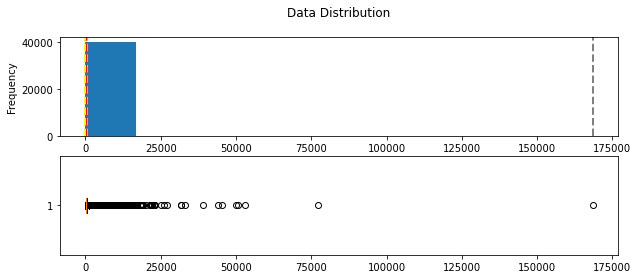

In [20]:
show_distribution(invoice_amount_df['Amount'])

Minimum:0.19
Mean:271.68
Median:256.24
Mode:15.00
Maximum:724.25



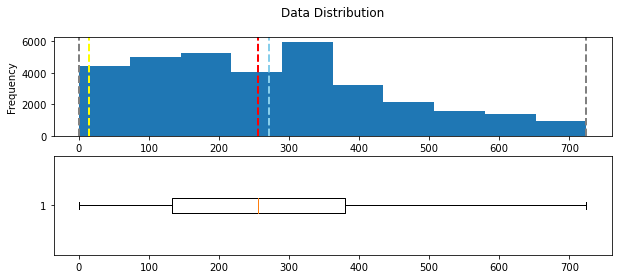

,invoice_no,Amount
0,489434,505.30
1,489435,145.80
2,489436,630.33
3,489437,310.75
5,489439,426.30


In [65]:
#Distribution of the first 85 quantiles 

#filter incoice_amount_df to keep the first 85 quantiles
q85 = invoice_amount_df['Amount'].quantile(0.85)
remove_outliers = invoice_amount_df[invoice_amount_df['Amount'] <= q85]
show_distribution(remove_outliers['Amount'])

# Monthly Placed and Canceled Orders

---
**Please remove this insturction cell after you are done with coding**

- The attribute information (see the `project kick-off` section) contains useful information that helps you to identify canceled orders
- To simplify the problem, you can assume that there are two invoice numbers for each canceled order (one for the original invoice and one for the canceled invoice). Therefore, `# of placed orders = total # of orders - 2 * canceled order`. Furthermore, you can also assume the original invoice and canceled invoice are on always on the same day (this eliminate the case where the original invoice and canceled invoices are on different months)
- hints: you might want to create a new integer column with YYYYMM format. e.g. `2009-12-01 07:45:00 -> 200912` which allows easy GROUP BY.

**Sample Plot:**

![](https://i.imgur.com/tmLsPDf.jpg)

---

In [66]:
retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


<AxesSubplot:xlabel='InvoiceYearMonth'>

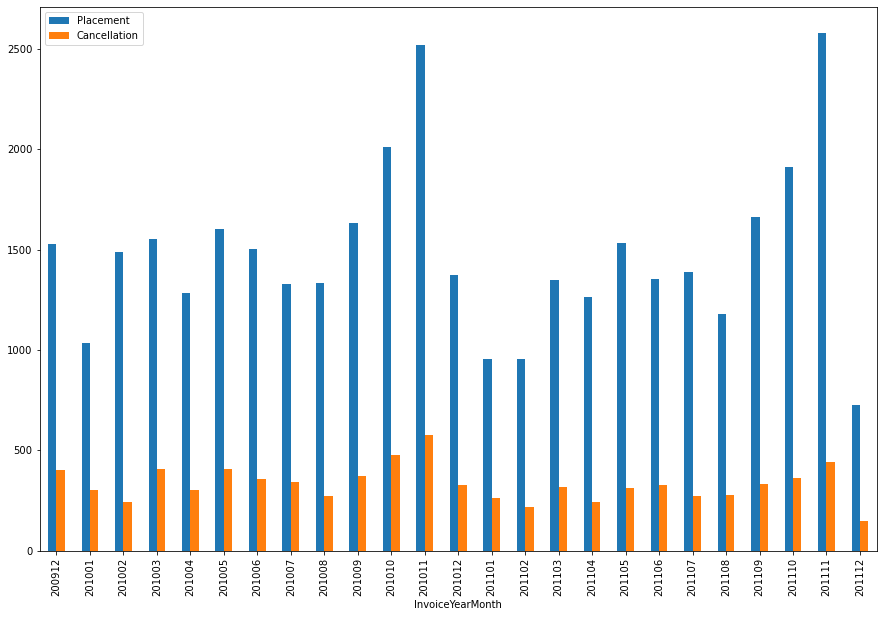

In [77]:
#Group Monthly placed  orders
retail_df['InvoiceYearMonth']= retail_df['invoice_date'].dt.strftime('%Y%m').astype(int)
retail_df['IsCancelled'] = retail_df['invoice_no'].astype(str).str.startswith('C')

monthly_total_orders = (
    retail_df
    .groupby('InvoiceYearMonth', as_index=False)['invoice_no']
    .nunique()
    .rename(columns={'invoice_no': 'TotalOrders'})
)

# 2. Canceled distinct invoices per month
monthly_canceled_orders_df = (
    retail_df[retail_df['IsCancelled']]
    .groupby('InvoiceYearMonth', as_index=False)['invoice_no']
    .nunique()
    .rename(columns={'invoice_no': 'Cancellation'})
)

# 3. Compute Placement = TotalOrders - 2 * Cancellation
monthly_placed_orders_df = (
    monthly_total_orders
    .merge(monthly_canceled_orders_df, on='InvoiceYearMonth', how='left')
    .fillna({'Cancellation': 0})
)

monthly_placed_orders_df['Cancellation'] = monthly_placed_orders_df['Cancellation'].astype(int)
monthly_placed_orders_df['Placement'] = (
    monthly_placed_orders_df['TotalOrders'] - 2 * monthly_placed_orders_df['Cancellation']
)

# keep only the columns needed for  concat
monthly_placed_orders_df = monthly_placed_orders_df[['InvoiceYearMonth', 'Placement']]

df = pd.concat(
    [monthly_placed_orders_df, monthly_canceled_orders_df['Cancellation']],
    axis=1
)

df.plot(
    x='InvoiceYearMonth',
    y=['Placement', 'Cancellation'],
    kind='bar',
    figsize=(15, 10)
)


---
**Please remove this insturction cell after you are done with coding**


- Calculate the monthly sales data
- Plot a chart to show monthly sales (e.g. x-asix=year_month, y-axis=sales_amount)

![](https://i.imgur.com/k1KOqKO.jpg)

---

<ipython-input-73-42a691e81729>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['invoice_amount'] = sales_df['unit_price'] * sales_df['quantity']


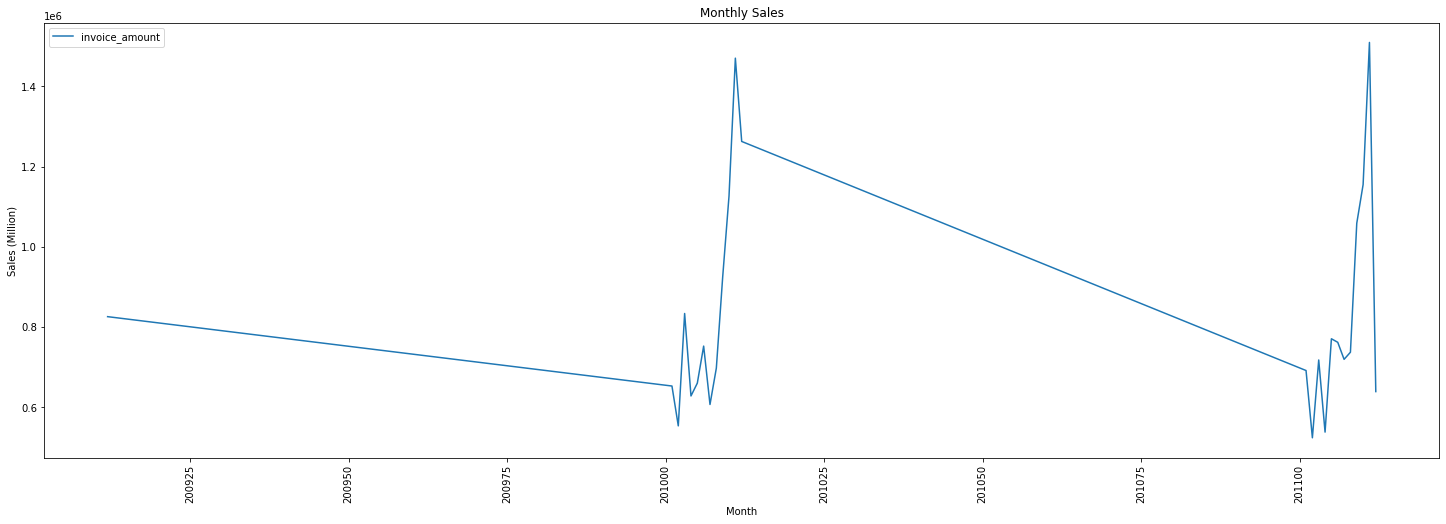

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,InvoiceYearMonth,IsCancelled,invoice_amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,False,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,False,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,False,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,False,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,False,30.0


In [73]:
#TO do


# Monthly Sales Growth


---
**Please remove this insturction cell after you are done with coding**

- Calculate monthly sales percentage growth data
- Plot a chart to show the growth percentage

![](https://i.imgur.com/J3btp8j.jpg)

---

In [ ]:
#TO do

# Monthly Active Users

---
**Please remove this insturction cell after you are done with coding**

- Compute # of active users (e.g. unique `CusotomerID`) for each month
- Plot a bar chart

![](https://i.imgur.com/eFYp8VF.jpg)

---

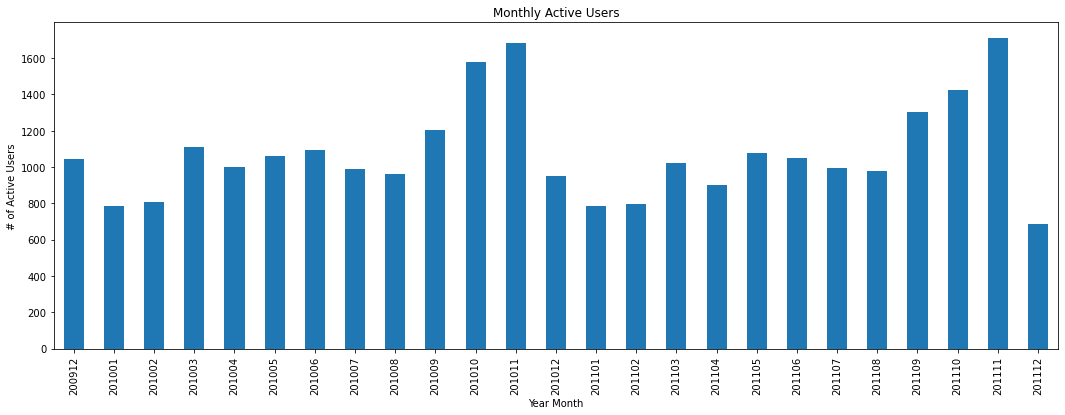

In [78]:
monthly_active_users = (
    retail_df
    .groupby('InvoiceYearMonth', as_index=False)['customer_id']
    .nunique()
)
ax = monthly_active_users.plot(
    x='InvoiceYearMonth',
    y='customer_id',
    kind='bar',
    figsize=(18, 6),
    legend=False
)

ax.set_title("Monthly Active Users")
ax.set_xlabel("Year Month")
ax.set_ylabel("# of Active Users")
plt.xticks(rotation=90)
plt.show()


# New and Existing Users



---
**Please remove this insturction cell after you are done with coding**

- Plot a diagram to show new and exiting user for each month.
- A user is identified as a new user when he/she makes the first purchase
- A user is identified as an existing user when he/she made purchases in the past
- hints:
  - find out the first purchase year-month for each user and then join this data with the transactional data to help you identified new/exiting users

![](https://i.imgur.com/nWjnrpr.jpg)

---

## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

# RFM Segmentation

---
**Please remove this insturction cell after you are done with coding**
RFM segmentation categorizes your customers into different segments, according to their interactions with your website, which will allow you to subsequently approach these groups in the most effective way. In this article, we will show you how to make an RFM segmentation based on an RFM score combining all three RFM parameters together and allowing you to divide your customers into 11 different segments. 

- [RFM Segmentation business cases](https://docs.exponea.com/docs/rfm-segmentation-business-use)

- [RFM Segmentation Guide](https://docs.exponea.com/docs/rfm-segmentation-business-use)

As you can see, computing RFM segmentation requires extensive domain knowledge in marketing which is out of the scope in this project. In practice, you will work with BA/DA to figure out how to compute RFM segments. To simplify this project, a [sample RFM segmentation Notebook](https://github.com/jarviscanada/jarvis_data_eng_demo/blob/feature/data/python_data_wrangling/ipynb/customer-segmentation-with-rfm-score.ipynb) is provided. You are responsible to understand everything from that Notebook and then integrate it into yours. 

- Download the [sample notebook](https://github.com/jarviscanada/jarvis_data_eng_demo/blob/feature/data/python_data_wrangling/ipynb/customer-segmentation-with-rfm-score.ipynb) and import to your Jupyter Notebook or VSCode
- Run the notebook and understand all cells
- Read the remark section at the end of the notebook. You will need this information when writing the README file
- Integrate the RFM segmentation calculation into your notebook

---